In [0]:
!apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y
!pip install git+https://github.com/hdfeos/pyhdf.git
!pip install matplotlib
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.tar.gz
!pip install pyproj==1.9.6


In [0]:
import os
import re
import pyproj
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import files
from mpl_toolkits.basemap import Basemap
from pyhdf.SD import SD, SDC


Upload HDF-EOS2 MODIS file.

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving MOD29E1D.A2000055.006.2015040211331.hdf to MOD29E1D.A2000055.006.2015040211331.hdf
User uploaded file "MOD29E1D.A2000055.006.2015040211331.hdf" with length 1626286 bytes


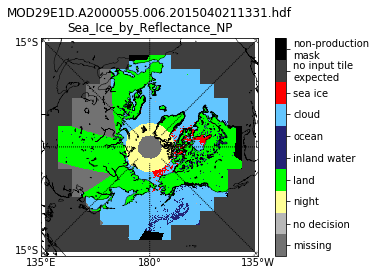

In [6]:
FILE_NAME = 'MOD29E1D.A2000055.006.2015040211331.hdf'
DATAFIELD_NAME = 'Sea_Ice_by_Reflectance_NP'
hdf = SD(FILE_NAME, SDC.READ)

# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:, :].astype(np.float64)

# Read global attribute.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]

# Construct the grid.  The needed information is in a global attribute
# called 'StructMetadata.0'.  Use regular expressions to tease out the
# extents of the grid.
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
(?P<upper_left_x>[+-]?\d+\.\d+)
,
(?P<upper_left_y>[+-]?\d+\.\d+)
\)''', re.VERBOSE)
match = ul_regex.search(gridmeta)
x0 = np.float(match.group('upper_left_x'))
y0 = np.float(match.group('upper_left_y'))

lr_regex = re.compile(r'''LowerRightMtrs=\(
(?P<lower_right_x>[+-]?\d+\.\d+)
,
(?P<lower_right_y>[+-]?\d+\.\d+)
\)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float(match.group('lower_right_x'))
y1 = np.float(match.group('lower_right_y'))

ny, nx = data.shape
x = np.linspace(x0, x1, nx)
y = np.linspace(y0, y1, ny)
xv, yv = np.meshgrid(x, y)

# Reproject the coordinates out of lamaz into lat/lon.
lamaz = pyproj.Proj("+proj=laea +a=6371228 +lat_0=90 +lon_0=0 +units=m")
wgs84 = pyproj.Proj("+init=EPSG:4326")
lon, lat = pyproj.transform(lamaz, wgs84, xv, yv)

# Use a south polar azimuthal equal area projection.
m = Basemap(projection='nplaea', resolution='l',
            boundinglat=20, lon_0=180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90, 0, 15), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180, 180, 45), labels=[0, 0, 0, 1])

# Use a discretized colormap since we have only a few levels.
# 0=missing data
# 1=no decision
# 11=night
# 25=land
# 37=inland water
# 39=ocean
# 50=cloud
# 200=sea ice
# 253=no input tile expected
# 254=non-production mask"
lst = ['#727272',
       '#b7b7b7',
       '#ffff96',
       '#00ff00',
       '#232375',
       '#232375',
       '#63c6ff',
       '#ff0000',
       '#3f3f3f',
       '#373737',
       '#000000']
cmap = mpl.colors.ListedColormap(lst)
bounds = [0, 1, 11, 25, 37, 39, 50, 200, 253, 254, 255]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Render only a subset of the mesh.
rows = slice(500, 4000, 5)
cols = slice(500, 4000, 5)
m.pcolormesh(lon[rows, cols], lat[rows, cols], data[rows, cols],
             latlon=True, cmap=cmap, norm=norm)
color_bar = plt.colorbar()
color_bar.set_ticks([0.5, 5.5, 18, 31,
                     38, 44.5, 125, 226.5,
                     253.5,
                     254.5])
color_bar.set_ticklabels(['missing', 'no decision', 'night', 'land',
                          'inland water', 'ocean', 'cloud', 'sea ice',
                          'no input tile\nexpected',
                          'non-production\nmask'])
color_bar.draw_all()

basename = os.path.basename(FILE_NAME)
long_name = DATAFIELD_NAME

plt.title('{0}\n{1}'.format(basename, long_name))
fig = plt.gcf()
pngfile = "{0}.py.png".format(basename)
fig.savefig(pngfile)
